In [124]:
%pylab inline

import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import os

from IPython.display import clear_output
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_boston, load_diabetes
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# Introduction

Machine learning 그리고 deep learning은 단순히 연구에서 머물지 않고, 실제 서비스 그리고 엔터프라이즈 환경에서 사용이 되고 있습니다.<br>
하나의 모델을 만들고 튜닝하는데에는 ML engineer의 고도화된 튜닝 기법들이 필요합니다.<br>
문제는 튜닝을 하는데 많은 시간이 소요가 되며, 이것은 낮은 생산성으로 이어지게 됩니다. <br>
특히 딥러닝의 경우 정말 많은 hyperparameters 가 존재합니다. <br>
모델의 아키텍쳐, learning rate, epsilon value, drop rate 등등 종속변수에 영향을 미치는 변수들이 상당히 많습니다. <br>
현실적인 관점에서 기존 ML은 그나마 좀 빠르게 학습되는데 반해서, 딥러닝 모델의 경우 모델에 따라서 몇일이 걸리는 일도 발생합니다. 

Auto ML은 다음의 3가지의 문제를 해결하는데 도움을 줍니다. 

1. **Time Saving**: Auto ML은 data extraction 그리고 algorithm tuning을 자동으로 하면서, 수작업으로 하던 일들을 크게 줄여줍니다.
2. **Improved Accuracy**: 실제 업무를 하다보면, 모델이 나오는 것까지는 하지만 튜닝에 들어가는 시간이 없어서 대충 기본값만 사용하는 케이스가 꽤 많습니다. 이러한 일들이 자동으로 되면서 휴먼 에러를 줄이고, 일정상 못하던 튜닝이 자동으로 되면서 매우 높은 accuracy로 향상 시킬수 있습니다.

# Data

## Regression Data

In [14]:
def regression_data():
    np.random.seed(2685)
    x_data, y_data = load_diabetes(True)
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,)
    columns = load_diabetes()['feature_names']
    
    return x_train, y_train, x_test, y_test, columns

def visualize_regression(y_true, y_pred):
    fig, plot = subplots(1, figsize=(9, 6))
    sns.scatterplot(np.arange(len(y_pred)), y_pred, label='blue', ax=plot)
    sns.scatterplot(np.arange(len(y_pred)), y_test, color='red', label='true', ax=plot)
    print('RMSE:', mean_squared_error(y_test, y_pred) ** 0.5)
    print('R^2 :', r2_score(y_test, y_pred) ** 0.5)

# Models

Auto ML을 사용안했을때와 비교하기 위해서 만듬


## Decision Tree

RMSE: 72.95889253545451
R^2 : 0.25863112218664946


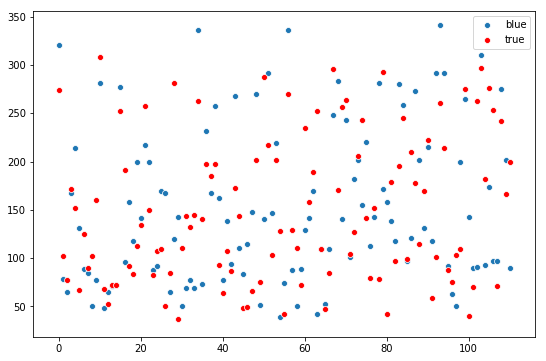

In [42]:
from sklearn.tree import DecisionTreeRegressor
x_train, y_train, x_test, y_test, columns = regression_data()

dt = DecisionTreeRegressor()
dt.fit(x_train, y_train)

# Evaluation
y_pred = dt.predict(x_test)

visualize_regression(y_test, y_pred)

## LightGBM Regression

RMSE: 55.77017350273214
R^2 : 0.6743658124542955


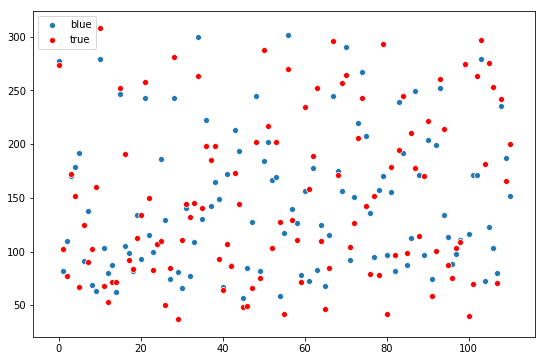

In [38]:
# Data
x_train, y_train, x_test, y_test, columns = regression_data()

# LightGBM Regression Model
gbm = lgb.LGBMRegressor(seed=0)
gbm.fit(x_train, y_train, 
        eval_metric='l2', 
        verbose=False)

# Evaluation
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

visualize_regression(y_test, y_pred)

## Deep Learning

RMSE: 57.60575894646961
R^2 : 0.64675174616162


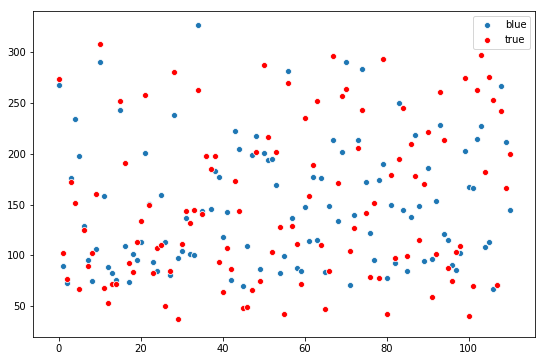

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow import set_random_seed
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
set_random_seed(0)

# Data
x_train, y_train, x_test, y_test, columns = regression_data()

# Scaling
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))

model = Sequential()
model.add(Dense(128, input_shape=(10,), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',  optimizer='adam',)

es = EarlyStopping(monitor='val_loss', patience=20)
model.fit(x_train, y_train, batch_size=32, epochs=64, validation_data=(x_test, y_test), 
          callbacks=[es], verbose=0)

y_pred = model.predict(x_test)
y_pred = y_scaler.inverse_transform(y_pred).reshape(-1)
visualize_regression(y_test, y_pred)

# Auto-Sklearn


## Installation

설치는 다음과 같이 합니다. 

```
sudo pip install auto-sklearn
```


## Seachspace 줄이기
Seachspace를 줄이기 위해서는 다음과 같이 합니다.

```
automl = autosklearn.classification.AutoSklearnClassifier(
    include_estimators=["random_forest", ], exclude_estimators=None,
    include_preprocessors=["no_preprocessing", ], exclude_preprocessors=None)
```

Auto-Sklearn은 data preprocessing 그리고 feature preprocessing 두가지로 나뉩니다. <br>
data preprocessing은 현재 없앨수 없으며, feature preprocessing은 `include_preprocessors=["no_preprocessing"]` 으로 끌수 있습니다.

**Data Preprocessing** : 끌수 없음
 - one hot encoding of categorical features
 - imputation of missing values 
 - normalization of features or samples

**Feature Preprocessing**: 끌수 있음
 - Feature selection 
 - Trasformation of features into a different space (PCA)
 
 



string 부분은 아래 링크의 파일 이름을 적으면 됩니다.

- [Classifiers](https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components/classification)
- [Regressors](https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components/regression)
- [Preprocessors](https://github.com/automl/auto-sklearn/tree/master/autosklearn/pipeline/components/feature_preprocessing)

## Regression Example

In [44]:
from autosklearn.regression import AutoSklearnRegressor
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

x_train, y_train, x_test, y_test, columns = regression_data()

automl = AutoSklearnRegressor(time_left_for_this_task=300, 
                              include_preprocessors=["no_preprocessing"],
                              per_run_time_limit=30,
                              n_jobs=32)
automl.fit(x_train, y_train, x_test, y_test)

[19:06:43] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:06:43] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[WARNING] [2019-12-18 19:06:43,814:AutoMLSMBO(1791095845)::3fe0d00d6db20f82286eea617111a6ed] Could not find meta-data directory /usr/local/lib/python3.6/site-packages/autosklearn/metalearning/files/r2_regression_dense
[19:06:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:06:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:06:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:06:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:06:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:06:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:06:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:06:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:06:44] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:06:44] /

[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:01] /workspac

[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:02] /workspac

[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:03] /workspac

[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:07:22] /workspac

[19:07:28] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:28] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:33] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:33] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:37] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:37] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:37] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:37] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:43] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:43] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:07:48] /workspace/src/gbm/gbtree.cc:492: drop 32 trees, weight = 0.03125
[19:07:48] /workspace/src/gbm/gbtree.cc:492: drop 33 trees, weight = 0.030303
[19:07:48] /workspace/src/gbm/gbtree.cc:492: drop 34 trees, weight = 0.0294118
[19:07:48] /workspace/src/gbm/gbtree.cc:492: drop 35 trees, weight

[19:08:48] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:08:48] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:08:48] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:08:48] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:08:48] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:08:53] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:08:53] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:09:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:09:01] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:09:04] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:09:04] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:09:10] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:09:10] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:09:15] /workspace/src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[19:09:15] /workspac

[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspace/src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[19:11:10] /workspac

Process Process-28:
json.decoder.JSONDecodeError: Expecting value: line 1 column 73820 (char 73819)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/autosklearn/estimators.py", line 15, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/autosklearn/automl.py", line 1091, in fit
    load_models=load_models,
  File "/usr/local/lib/python3.6/site-packages/autosklearn/automl.py", line 208, in fit
    only_return_configuration_space=only_return_configuration_space,
  File "/usr/local/lib/python3.6/site-packages/autosklearn/automl.py", line 489, in _fit
    _proc_smac.run_smbo()
  File "/usr/local/lib/python3.6/site-packages/autosklearn/smbo.py", line 513, in run_smbo
   

-1
['/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000007.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000008.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000009.ensemble', '/tmp/autosklearn_tmp_17833_6063/.auto-sklearn/ensembles/1791095845.0000000010.ensemble', '/tmp/

AutoSklearnRegressor(delete_output_folder_after_terminate=False,
           delete_tmp_folder_after_terminate=False,
           disable_evaluator_output=False, ensemble_memory_limit=1024,
           ensemble_nbest=50, ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None,
           include_preprocessors=['no_preprocessing'],
           initial_configurations_via_metalearning=25, logging_config=None,
           metadata_directory=None, ml_memory_limit=3072, n_jobs=32,
           output_folder=None, per_run_time_limit=30,
           resampling_strategy='holdout',
           resampling_strategy_arguments=None, seed=1, shared_mode=False,
           smac_scenario_args=None, time_left_for_this_task=300,
           tmp_folder=None)

auto-sklearn results:
  Dataset name: 3fe0d00d6db20f82286eea617111a6ed
  Metric: r2
  Best validation score: 0.540428
  Number of target algorithm runs: 5036
  Number of successful target algorithm runs: 4221
  Number of crashed target algorithm runs: 689
  Number of target algorithms that exceeded the time limit: 126
  Number of target algorithms that exceeded the memory limit: 0


RMSE: 51.36174624473981
R^2 : 0.7331844558057462


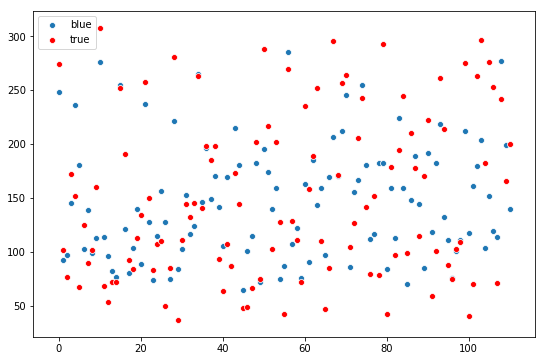

In [45]:
y_pred = automl.predict(x_test)

print(automl.sprint_statistics())
print()
visualize_regression(y_test, y_pred)

모델을 직접 사용해서 prediction하는 방법은 다음과 같이 합니다.

RMSE: 51.36174533976978
R^2 : 0.7331844669188936


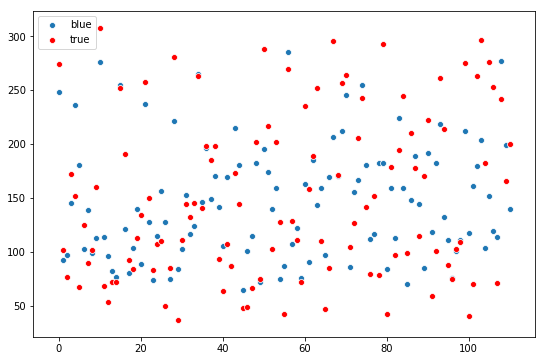

In [46]:
y_preds = []
for weight, model in automl.get_models_with_weights():
    y_pred = model.predict(x_test)
    y_preds.append(y_pred * weight)
    
y_pred = np.sum(y_preds, axis=0)
visualize_regression(y_test, y_pred)

# MLBox

설치는 다음과 같이 합니다. 

```
sudo pip install mlbox
```

### Reading Data

 - train 그리고 test 데이터 구분 방법은 y 컬럼이 있는지 없는지로 구분
 - 반드시 csv 파일로 읽어야 됨

In [242]:
from mlbox.preprocessing import Reader, Drift_thresholder
from mlbox.optimisation import Optimiser
from mlbox.prediction import Predictor
from mlbox.model.regression import Regressor

# Data
x_train, y_train, x_test, y_test, columns = regression_data()
if not os.path.exists('test.csv'):
    pd.DataFrame(np.c_[x_train, y_train], columns=columns + ['y']).to_csv('train.csv')
    pd.DataFrame(x_test, columns=columns).to_csv('test.csv')
    
# Make Reader
paths = ['train.csv', 'test.csv']
rd = Reader(sep=',', to_path='mlbox_save')
rd_data = rd.train_test_split(paths, target_name='y')

# Drift Thresholding
# 자동으로 id 그리고 drifting variables을 삭제 시킵니다. 
rd_data = Drift_thresholder(to_path='mlbox_save').fit_transform(rd_data)


reading csv : train.csv ...
cleaning data ...
CPU time: 11.58510971069336 seconds

reading csv : test.csv ...
cleaning data ...


/usr/local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU time: 8.833452939987183 seconds

> Number of common features : 10

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 10
> Number of training samples : 331
> Number of test samples : 111

> You have no missing values on train set...

> Task : regression
count    331.000000
mean     152.719033
std       77.603282
min       25.000000
25%       87.500000
50%      141.000000
75%      214.000000
max      346.000000
Name: y, dtype: float64

computing drifts ...
CPU time: 2.1213438510894775 seconds

> Top 10 drifts

('s3', 0.17542809372080992)
('s5', 0.12918394356647367)
('sex', 0.11962525426380854)
('s4', 0.09655719691042819)
('bmi', 0.07487024840803613)
('age', 0.06448746580181419)
('s6', 0.05461560527825604)
('s2', 0.02647062275074319)
('s1', 0.016229303281603435)
('bp', 4.894430140867101e-0

### Optimization

optimization을 하기 위해서는 다음과 같이 합니다.

 - **ne**: missing data encoder
 - **ce**: categorical variables
 - **fs**: feature selector
 - **stck**: meta-features stacker
 - **est**: final estimator

In [248]:
from lightgbm import LGBMRegressor

LGBMRegressor()

In [255]:
space = {
    'ne__numerical_strategy': {'space': [0, 'mean', 'median', None]},
    
    'fs__strategy' : {"space" : ["variance", "rf_feature_importance", 'l1']},
    'fs__threshold': {"search" : "choice", "space" : [0.01, 0.05, 0.1, 0.2, 0.3]},
    
    
    'est__strategy': {'space': ['LightGBM', 'RandomForest', 'AdaBoost', 'Bagging']},
    'est__boosting_type': {'search': 'choice', 'space': ['gbdt', 'gbdt', 'dart', 'goss', 'rf']},
    'est__num_leaves': {'search': 'uniform', 'space': [20, 60]}, 
    'est_learning_rate': {'search': 'uniform', 'space': [0.01, 1]}
}

opt = Optimiser()
best = opt.optimise(space, rd_data, max_evals=5)

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]


/usr/local/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


ValueError: Pipeline cannot be set with these parameters. Check the name of your stages.

/usr/local/lib/python3.6/site-packages/mlbox/model/regression/regressor.py:82: UserWarning: Invalid parameter for regressor RandomForest. Parameter IGNORED. Check the list of available parameters with `regressor.get_params().keys()`
  + ". Parameter IGNORED. Check the list of "



fitting the pipeline ...
CPU time: 1.476050615310669 seconds


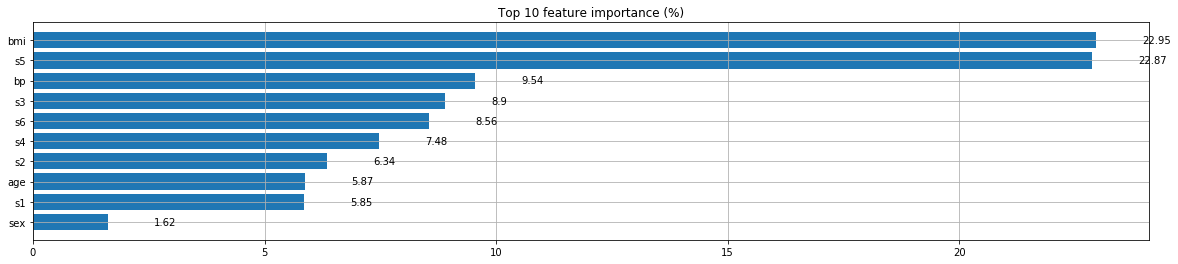


> Feature importances dumped into directory : mlbox_save

predicting...
CPU time: 0.22762346267700195 seconds

> Overview on predictions : 

   y_predicted
0   245.393621
1   105.344685
2    93.853038
3   166.788678
4   192.476475
5   178.891047
6    95.449663
7   165.219532
8    94.679176
9    83.509388

dumping predictions into directory : mlbox_save ...
RMSE: 51.69191819572817
R^2 : 0.7291055238350539


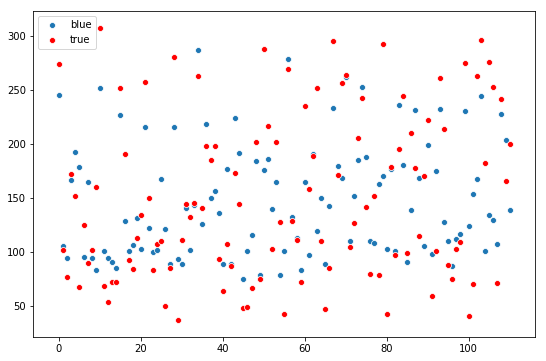

In [254]:
pred = Predictor(to_path='mlbox_save').fit_predict(best, rd_data)
y_pred = np.loadtxt('mlbox_save/y_predictions.csv', skiprows=1, delimiter=',')[:, 1]
visualize_regression(y_test, y_pred)

### Drift Thresholding

자동으로 id 그리고 drifting variables 을 삭제시킵니다.

In [177]:
rdf.keys()


dict_keys(['train', 'test', 'target'])

In [178]:
rdf['test'].shape, y_train.shape

((111, 10), (331,))